In [1]:
# Import packages

import numpy as np

import tensorflow as tf

import wf_psf as wf
import wf_psf.SimPSFToolkit as SimPSFToolkit
import wf_psf.utils as wf_utils
import wf_psf.tf_psf_field as tf_psf_field


# Plot style & colormap
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import ImageGrid

# Pre-defined colormap
top = mpl.colormaps['Oranges_r'].resampled(128)
bottom = mpl.colormaps['Blues'].resampled(128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')


/Users/tl255879/miniconda3/envs/wf_tools/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
# %matplotlib inline
params = {
    "font.size": 18,
    "legend.fontsize": 18,
    "legend.frameon": False,
    "axes.labelsize": 18,
    "axes.titlesize": 18,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "figure.figsize": (7, 5),
    "xtick.top": True,
    "axes.unicode_minus": False,
    "ytick.right": True,
    "xtick.bottom": True,
    "ytick.left": True,
    "xtick.major.pad": 8,
    "xtick.major.size": 8,
    "xtick.minor.size": 4,
    "ytick.major.size": 8,
    "ytick.minor.size": 4,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "axes.linewidth": 1.5,
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": "cmr10",
    "mathtext.fontset": "cm",
    "axes.formatter.use_mathtext": True,  # needed when using cm=cmr10 for normal text
}


mpl.rcParams.update(params)


In [3]:

save_dir = './../plots/'
plot_results = True

repo_dir = "./../../../"


star_cat = np.load(
    repo_dir + "data/phase_retrieval_dataset/train_Euclid_res_2000_TrainStars_id_010_8_bins.npy",
    allow_pickle=True
)[()]


In [4]:


star_cat.keys()

dict_keys(['stars', 'noisy_stars', 'super_res_stars', 'positions', 'SEDs', 'zernike_coef', 'C_poly', 'parameters'])

In [5]:

args = {
    'id_name': '_wf_PR_NewPRoj_12_cycles_v2' ,
    'suffix_id_name': 'v2' ,
    'base_id_name': '_wf_PR_NewPRoj_12_cycles_' ,
    'eval_only_param': False ,
    'total_cycles': 12 ,
    'saved_cycle': 'cycle12' ,
    'reset_dd_features': True ,
    'eval_only_param': False ,
    'project_dd_features': True ,
    'd_max': 2 ,
    'n_zernikes': 45 ,
    'save_all_cycles': True ,
    'n_bins_lda': 8,
    'n_bins_gt': 8,
    'output_dim': 32,
    'batch_size': 32,
    'oversampling_rate': 3.,
    'output_q': 3.,
    'sed_sigma': 0.,
    'x_lims': [0, 1e3],
    'y_lims': [0, 1e3],
    'sed_interp_kind': 'linear',
    'interp_pts_per_bin': 0,
    'extrapolate': True,
    'opt_stars_rel_pix_rmse': True ,
    'eval_mono_metric_rmse': False,
    'eval_opd_metric_rmse': True,
    'eval_train_shape_sr_metric_rmse': True,
    'pupil_diameter': 256 ,
    'n_epochs_param_multi_cycle': "0" ,
    'n_epochs_non_param_multi_cycle': "75" ,
    'l_rate_non_param_multi_cycle': "0.1" ,
    'l_rate_param_multi_cycle': "0" ,
    'l_rate_param': None,
    'l_rate_non_param': None,
    'n_epochs_param': None,
    'n_epochs_non_param': None,
    'model': 'poly' ,
    'model_eval': 'poly' ,
    'cycle_def': 'complete' ,
    'gt_n_zernikes': 45 ,
    'd_max_nonparam': 5 ,
    'saved_model_type': 'external' ,
    'use_sample_weights': True ,
    'l2_param': 0. ,
    'interpolation_type': 'none' ,
    'eval_batch_size': 16 ,
    'train_opt': True ,
    'eval_opt': True ,
    'plot_opt': True ,
    'dataset_folder': '.',
    'test_dataset_file': 'test_Euclid_res_id_010_8_bins.npy',
    'train_dataset_file': 'train_Euclid_res_2000_TrainStars_id_010_8_bins.npy',
    'base_path': '.',
    'metric_base_path': '.',
    'chkp_save_path': '.',
    'plots_folder': 'plots/' ,
    'model_folder': 'chkp/' ,
    'log_folder': 'log-files/' ,
    'optim_hist_folder': 'optim-hist/' ,
    'star_numbers': 1 ,
}

In [6]:
## Prepare ground truth model
# Generate Zernike maps
zernikes = wf_utils.zernike_generator(n_zernikes=args['gt_n_zernikes'], wfe_dim=args['pupil_diameter'])
# Now as cubes
np_zernike_cube = np.zeros((len(zernikes), zernikes[0].shape[0], zernikes[0].shape[1]))
for it in range(len(zernikes)):
    np_zernike_cube[it,:,:] = zernikes[it]

np_zernike_cube[np.isnan(np_zernike_cube)] = 0
tf_zernike_cube = tf.convert_to_tensor(np_zernike_cube, dtype=tf.float32)

# Prepare np input
simPSF_np = SimPSFToolkit(
    zernikes,
    max_order=args['n_zernikes'],
    pupil_diameter=args['pupil_diameter'],
    output_dim=args['output_dim'],
    oversampling_rate=args['oversampling_rate'],
    output_Q=args['output_q']
)
simPSF_np.gen_random_Z_coeffs(max_order=args['n_zernikes'])
z_coeffs = simPSF_np.normalize_zernikes(simPSF_np.get_z_coeffs(), simPSF_np.max_wfe_rms)
simPSF_np.set_z_coeffs(z_coeffs)
simPSF_np.generate_mono_PSF(lambda_obs=0.7, regen_sample=False)

# Obscurations
obscurations = simPSF_np.generate_pupil_obscurations(N_pix=args['pupil_diameter'], N_filter=2)
tf_obscurations = tf.convert_to_tensor(obscurations, dtype=tf.complex64)


# Initialize the model
GT_tf_semiparam_field = tf_psf_field.TF_SemiParam_field(
    zernike_maps=tf_zernike_cube,
    obscurations=tf_obscurations,
    batch_size=args['batch_size'],
    output_Q=args['output_q'],
    d_max_nonparam=args['d_max_nonparam'],
    output_dim=args['output_dim'],
    n_zernikes=args['gt_n_zernikes'],
    d_max=args['d_max'],
    x_lims=args['x_lims'],
    y_lims=args['y_lims']
)

# For the Ground truth model
GT_tf_semiparam_field.tf_poly_Z_field.assign_coeff_matrix(star_cat['C_poly'])
_ = GT_tf_semiparam_field.tf_np_poly_opd.alpha_mat.assign(
    np.zeros_like(GT_tf_semiparam_field.tf_np_poly_opd.alpha_mat)
)

GT_tf_semiparam_field = wf.tf_psf_field.build_PSF_model(
    GT_tf_semiparam_field,
    optimizer = tf.keras.optimizers.legacy.Adam(
            learning_rate=1e-2, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False
        )
)


2024-06-20 12:36:00.081169: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-06-20 12:36:00.081212: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-06-20 12:36:00.081238: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-06-20 12:36:00.081365: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-20 12:36:00.081391: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Printing random seed
None
Printing random seed
None


In [7]:
tick_size = 16
offset_text_size = 18

n_figs = 4

id_list = [1, 10, 19, 100]



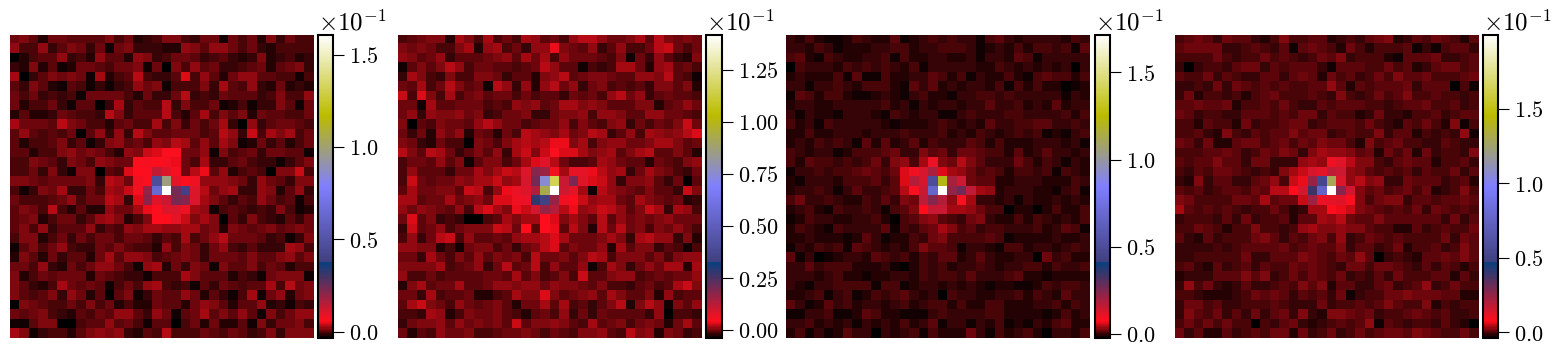

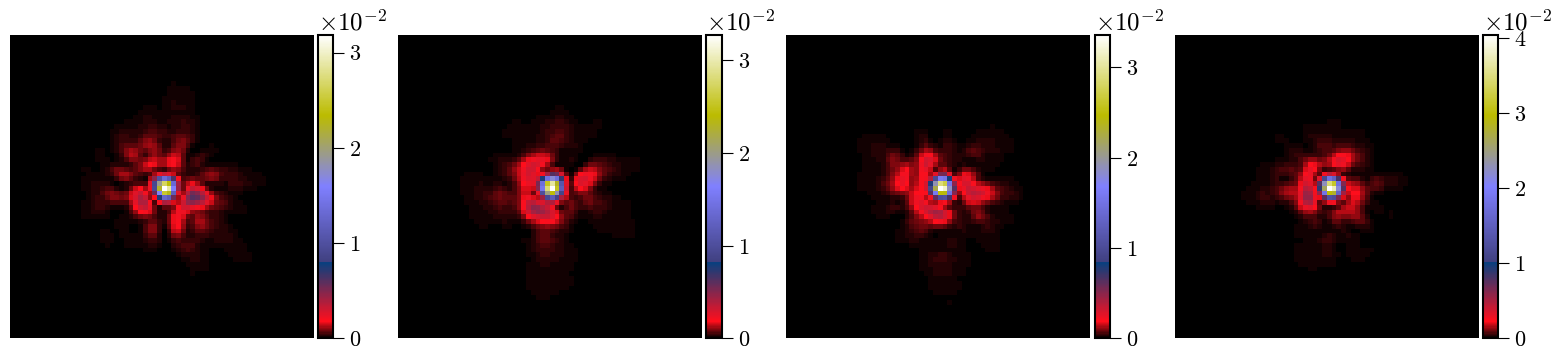

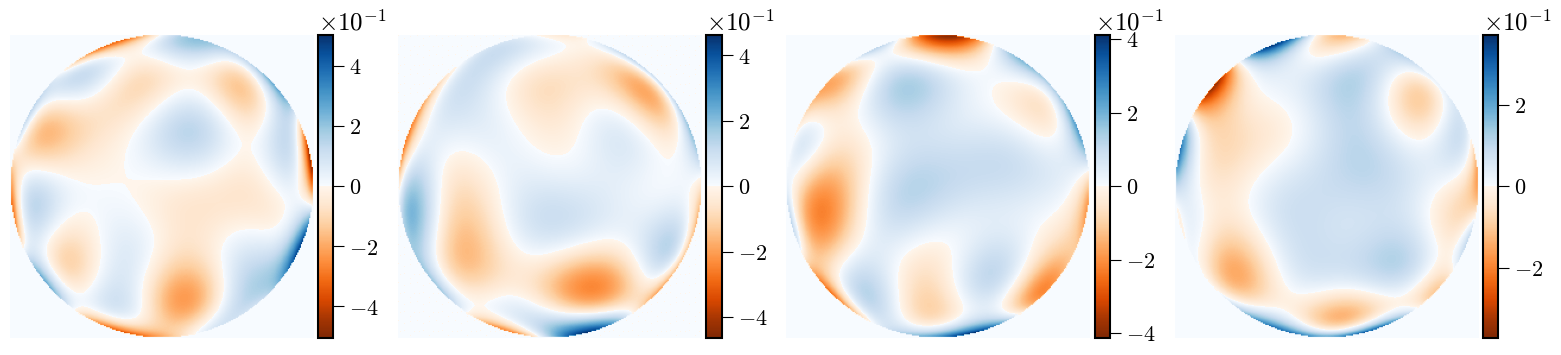

In [8]:

# Pixel observation
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.2)

for it in range(n_figs):
    vmax = np.max(star_cat['noisy_stars'][id_list[it],:,:])
    im = axs[it].imshow(star_cat['noisy_stars'][id_list[it],:,:], cmap='gist_stern')
    divider = make_axes_locatable(axs[it])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(im, cax=cax)#, extend='both')
    cbar.minorticks_on()
    cbar.ax.tick_params(labelsize=tick_size, direction="out")
    cbar.formatter.set_powerlimits((0, 0))
    cbar.ax.yaxis.offsetText.set(size=offset_text_size)
    cbar.ax.yaxis.set_offset_position('left')
    cbar.update_ticks()
    axs[it].set_xticks([])
    axs[it].set_yticks([])
    axs[it].spines['top'].set_visible(False)
    axs[it].spines['right'].set_visible(False)
    axs[it].spines['bottom'].set_visible(False)
    axs[it].spines['left'].set_visible(False)

if plot_results:
    plt.savefig(
        '{:s}{:s}'.format(save_dir, 'observations_noisy_stars.pdf'),
        bbox_inches='tight',
        dpi=200
    )

plt.show()

# Pixel super resolution
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.2)

for it in range(n_figs):
    vmax = np.max(star_cat['super_res_stars'][id_list[it],:,:])
    im = axs[it].imshow(star_cat['super_res_stars'][id_list[it],:,:], cmap='gist_stern',vmin=0)
    divider = make_axes_locatable(axs[it])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(im, cax=cax)#, extend='both')
    cbar.minorticks_on()
    cbar.ax.tick_params(labelsize=tick_size, direction="out")
    cbar.formatter.set_powerlimits((0, 0))
    cbar.ax.yaxis.offsetText.set(size=offset_text_size)
    cbar.ax.yaxis.set_offset_position('left')
    cbar.update_ticks()
    axs[it].set_xticks([])
    axs[it].set_yticks([])
    axs[it].spines['top'].set_visible(False)
    axs[it].spines['right'].set_visible(False)
    axs[it].spines['bottom'].set_visible(False)
    axs[it].spines['left'].set_visible(False)

if plot_results:
    plt.savefig(
        '{:s}{:s}'.format(save_dir, 'observations_super_res_stars.pdf'),
        bbox_inches='tight',
        dpi=200
    )

plt.show()



# Wavefront representations
# We calculate a batch of OPDs
batch_pos = star_cat['positions'][id_list[:n_figs],:]
GT_opd_batch = GT_tf_semiparam_field.predict_opd(batch_pos)

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.2)

for it in range(n_figs):
    vmax = np.max(np.abs(GT_opd_batch[it,:,:]))
    im = axs[it].imshow(GT_opd_batch[it,:,:], cmap=newcmp, vmax=vmax, vmin=-vmax)
    divider = make_axes_locatable(axs[it])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(im, cax=cax)#, extend='both')
    cbar.minorticks_on()
    cbar.ax.tick_params(labelsize=tick_size, direction="out")
    cbar.formatter.set_powerlimits((0, 0))
    cbar.ax.yaxis.offsetText.set(size=offset_text_size)
    cbar.ax.yaxis.set_offset_position('left')
    cbar.update_ticks()
    axs[it].set_xticks([])
    axs[it].set_yticks([])
    axs[it].spines['top'].set_visible(False)
    axs[it].spines['right'].set_visible(False)
    axs[it].spines['bottom'].set_visible(False)
    axs[it].spines['left'].set_visible(False)

if plot_results:
    plt.savefig(
        '{:s}{:s}'.format(save_dir, 'observations_OPD.pdf'),
        bbox_inches='tight',
        dpi=200
    )
plt.show()
